## Comparative Analysis: 56x28 Model vs. Sequential 28x28 Model

This notebook explores the performance of two models:
1. **56x28 Model**: A single linear classifier that directly predicts sums from paired digit images of size 56x28.
2. **Sequential 28x28 Model**: Two linear classifiers that process paired digit images split into two 28x28 segments. The predictions for each segment are summed to obtain the final prediction.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from utils.data_utils import *
from utils.model_utils import *
from utils.common_imports import *

# Set reproducibility
set_reproducibility(42)
# Use the custom style
plt.style.use('latex_style.mplstyle')

/Users/shahabnasiri/Library/Mobile Documents/com~apple~CloudDocs/All/CAMBRIDGE/M1/m1_ml_for_dis/mnist_addition/mnist_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
training_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 75000]
validation_size = 8000
test_size = 2000
# Prepare datasets
datasets_56x28 = {}
datasets_28x28 = {}
for size in training_sizes:
    datasets_56x28[size] = prepare_datasets(
        mode="56x28",
        data_percentage=size / 60000,
        validation_size=validation_size,
        test_size=test_size,
    )
    datasets_28x28[size] = prepare_datasets(
        mode="28x28",
        data_percentage=size / 60000,
        validation_size=validation_size,
        test_size=test_size,
    )

### Model Definition and Training
In this section, we define the `WeakLinearClassifier` and implement the `train_model` function:
- **WeakLinearClassifier**: A simple linear model with a single layer for predictions.
- **train_model**:
  - Trains a given model on the training data.
  - Evaluates performance on validation data after each epoch.
  - Tracks training and validation losses for analysis.
  - Saves the best-performing model based on validation loss.

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# Define the weak linear classifier
class WeakLinearClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(WeakLinearClassifier, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        return self.linear(x)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    """
    Trains a model on the given train_loader and evaluates on val_loader.
    Collects and returns train and validation losses for each epoch.
    """
    model.to(device)
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()

    model.load_state_dict(best_model)
    return model, train_losses, val_losses


### Evaluation and Results Visualization
This section focuses on:
- **Evaluation**:
  - `evaluate_56x28`: Evaluates the 56x28 model on the 56x28 test dataset.
  - `evaluate_28x28_sequential`: Evaluates the sequential 28x28 model by processing and summing predictions for two 28x28 segments of the 56x28 test data.
- **Visualization**:
  - **Accuracy vs. Dataset Size**: Plots accuracy trends for both models as training dataset size increases.
  - **Loss vs. Dataset Size**: Plots training and validation losses for both models as dataset size increases.


In [4]:
def evaluate_56x28(model, test_loader, device):
    """
    Evaluates the 56x28 model on the test_loader.
    """
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            preds = torch.argmax(outputs, axis=1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return accuracy_score(y_true, y_pred)

def evaluate_28x28_sequential(model, test_loader, device):
    """
    Evaluates the 28x28 model sequentially on the 56x28 test_loader.
    """
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x1, x2 = x_batch[:, :784], x_batch[:, 784:]  # Split 56x28 into two 28x28
            x1, x2 = x1.to(device), x2.to(device)
            y_batch = y_batch.to(device)

            # Predict each image
            preds1 = torch.argmax(model(x1), axis=1)
            preds2 = torch.argmax(model(x2), axis=1)
            preds_sum = preds1 + preds2

            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds_sum.cpu().numpy())
    return accuracy_score(y_true, y_pred)

def plot_results(
    training_sizes, accuracies_56x28, accuracies_28x28, 
    train_losses_56x28, val_losses_56x28, 
    train_losses_28x28, val_losses_28x28
):
    """
    Plots model accuracies and losses as functions of training dataset size.
    """
    # Accuracy Plot
    plt.figure(figsize=(12, 6))
    plt.plot(training_sizes, accuracies_56x28, marker='o', label="56x28 Model Accuracy")
    plt.plot(training_sizes, accuracies_28x28, marker='o', label="28x28 Sequential Model Accuracy")
    plt.xlabel("Training Dataset Size")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy vs Dataset Size")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss Plot
    final_train_losses_56x28 = [losses[-1] for losses in train_losses_56x28]
    final_val_losses_56x28 = [losses[-1] for losses in val_losses_56x28]
    final_train_losses_28x28 = [losses[-1] for losses in train_losses_28x28]
    final_val_losses_28x28 = [losses[-1] for losses in val_losses_28x28]

    plt.figure(figsize=(12, 6))
    plt.plot(training_sizes, final_train_losses_56x28, marker='o', label="Train Loss (56x28)")
    plt.plot(training_sizes, final_val_losses_56x28, marker='o', label="Validation Loss (56x28)")
    plt.plot(training_sizes, final_train_losses_28x28, marker='o', label="Train Loss (28x28)")
    plt.plot(training_sizes, final_val_losses_28x28, marker='o', label="Validation Loss (28x28)")
    plt.xscale("log")  # Use logarithmic scale

    plt.xlabel("Training Dataset Size (log scale)")
    plt.ylabel("Loss")
    plt.title("Train and Validation Loss vs Dataset Size")
    plt.legend()
    plt.grid(True)
    plt.savefig("weak_linear.pdf", format="pdf")

    plt.show()



### Training and Evaluation Loop
This section implements the training and evaluation loop across varying dataset sizes:
- **Parameters**:
  - **Batch Size**: 32.
  - **Epochs**: 4.
  - **Learning Rate**: 0.001.
  - **Input Sizes**:
    - 56x28 Model: 1568 (flattened dimensions of 56x28).
    - 28x28 Model: 784 (flattened dimensions of 28x28).
  - **Number of Classes**:
    - 56x28 Model: Predicts sums in the range [0-18].
    - 28x28 Model: Predicts digits in the range [0-9].
- **Workflow**:
  - Train the 56x28 model on the 56x28 dataset and evaluate its accuracy.
  - Train the 28x28 model on the 28x28 dataset and evaluate its accuracy on the 56x28 test dataset (processed sequentially).
  - Store training/validation losses and accuracies for both models.
- **Goals**:
  - Compare model accuracy as a function of training dataset size.
  - Analyze differences in training dynamics (loss trends) between the two approaches.

In [5]:
#  Parameters
batch_size = 32
epochs = 15
learning_rate = 0.001
input_size_56x28 = 1568  # 56x28 flattened input size
input_size_28x28 = 784   # 28x28 flattened input size
num_classes = 19         # Sum range for 56x28 model (0-18)
num_classes_28x28 = 10   # Digit range for 28x28 model (0-9)
criterion = nn.CrossEntropyLoss()

In [7]:
import time

# Accuracy, loss, and timing results storage
accuracies_56x28 = []
accuracies_28x28 = []
train_losses_56x28 = []
val_losses_56x28 = []
train_losses_28x28 = []
val_losses_28x28 = []
training_times_56x28 = []
training_times_28x28 = []

# Training and evaluation loop
for size in training_sizes:
    print(f"\nTraining with dataset size: {size}")
    
    # Data Loaders for 56x28
    train_dataset_56x28, val_dataset_56x28, test_dataset_56x28 = datasets_56x28[size]
    train_loader_56x28, val_loader_56x28, test_loader_56x28 = create_data_loaders(
        train_dataset_56x28, val_dataset_56x28, test_dataset_56x28, batch_size
    )
    
    # Train 56x28 model
    model_56x28 = WeakLinearClassifier(input_size=input_size_56x28, num_classes=num_classes)
    optimizer = optim.Adam(model_56x28.parameters(), lr=learning_rate)
    
    # Start timing for 56x28
    start_time = time.time()
    model_56x28, train_loss_56x28, val_loss_56x28 = train_model(
        model_56x28, train_loader_56x28, val_loader_56x28, criterion, optimizer, epochs, device
    )
    elapsed_time_56x28 = time.time() - start_time  # End timing
    training_times_56x28.append(elapsed_time_56x28)  # Store training time
    
    train_losses_56x28.append(train_loss_56x28)
    val_losses_56x28.append(val_loss_56x28)
    
    # Evaluate 56x28 model
    acc_56x28 = evaluate_56x28(model_56x28, test_loader_56x28, device)
    accuracies_56x28.append(acc_56x28)
    print(f"56x28 Model Accuracy for size {size}: {acc_56x28:.4f}")
    print(f"56x28 Model Training Time for size {size}: {elapsed_time_56x28:.2f} seconds")
    
    # Data Loaders for 28x28
    train_dataset_28x28, val_dataset_28x28, test_dataset_28x28 = datasets_28x28[size]
    train_loader_28x28, val_loader_28x28, test_loader_28x28 = create_data_loaders(
        train_dataset_28x28, val_dataset_28x28, test_dataset_28x28, batch_size
    )
    
    # Train 28x28 model
    model_28x28 = WeakLinearClassifier(input_size=input_size_28x28, num_classes=num_classes_28x28)
    optimizer = optim.Adam(model_28x28.parameters(), lr=learning_rate)
    
    # Start timing for 28x28
    start_time = time.time()
    model_28x28, train_loss_28x28, val_loss_28x28 = train_model(
        model_28x28, train_loader_28x28, val_loader_28x28, criterion, optimizer, epochs, device
    )
    elapsed_time_28x28 = time.time() - start_time  # End timing
    training_times_28x28.append(elapsed_time_28x28)  # Store training time
    
    train_losses_28x28.append(train_loss_28x28)
    val_losses_28x28.append(val_loss_28x28)
    
    # Evaluate 28x28 model on 56x28 test data
    acc_28x28 = evaluate_28x28_sequential(model_28x28, test_loader_56x28, device)
    accuracies_28x28.append(acc_28x28)
    print(f"28x28 Sequential Model Accuracy for size {size}: {acc_28x28:.4f}")
    print(f"28x28 Model Training Time for size {size}: {elapsed_time_28x28:.2f} seconds")

# Optionally, save the timing results for further analysis
timing_results = {
    "training_sizes": training_sizes,
    "training_times_56x28": training_times_56x28,
    "training_times_28x28": training_times_28x28,
}



Training with dataset size: 100
Using 7 workers for DataLoader.
Epoch 1/15, Train Loss: 2.7818, Val Loss: 2.9619
Epoch 2/15, Train Loss: 2.4004, Val Loss: 3.1109
Epoch 3/15, Train Loss: 2.1846, Val Loss: 3.1684
Epoch 4/15, Train Loss: 2.0194, Val Loss: 3.1896
Epoch 5/15, Train Loss: 1.8317, Val Loss: 3.2061
Epoch 6/15, Train Loss: 1.7040, Val Loss: 3.2319
Epoch 7/15, Train Loss: 1.5934, Val Loss: 3.2510
Epoch 8/15, Train Loss: 1.4741, Val Loss: 3.2730
Epoch 9/15, Train Loss: 1.3556, Val Loss: 3.3045
Epoch 10/15, Train Loss: 1.2924, Val Loss: 3.3339
Epoch 11/15, Train Loss: 1.1918, Val Loss: 3.3585
Epoch 12/15, Train Loss: 1.1099, Val Loss: 3.3723
Epoch 13/15, Train Loss: 1.0367, Val Loss: 3.4017
Epoch 14/15, Train Loss: 0.9703, Val Loss: 3.4376
Epoch 15/15, Train Loss: 0.9012, Val Loss: 3.4477
56x28 Model Accuracy for size 100: 0.1240
56x28 Model Training Time for size 100: 126.36 seconds
Using 7 workers for DataLoader.
Epoch 1/15, Train Loss: 2.2175, Val Loss: 2.1649
Epoch 2/15, Trai

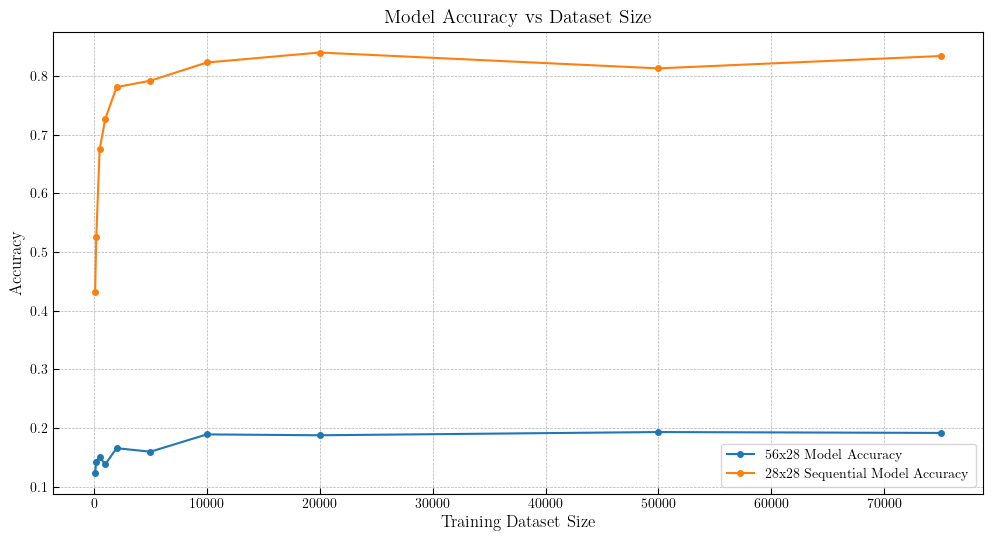

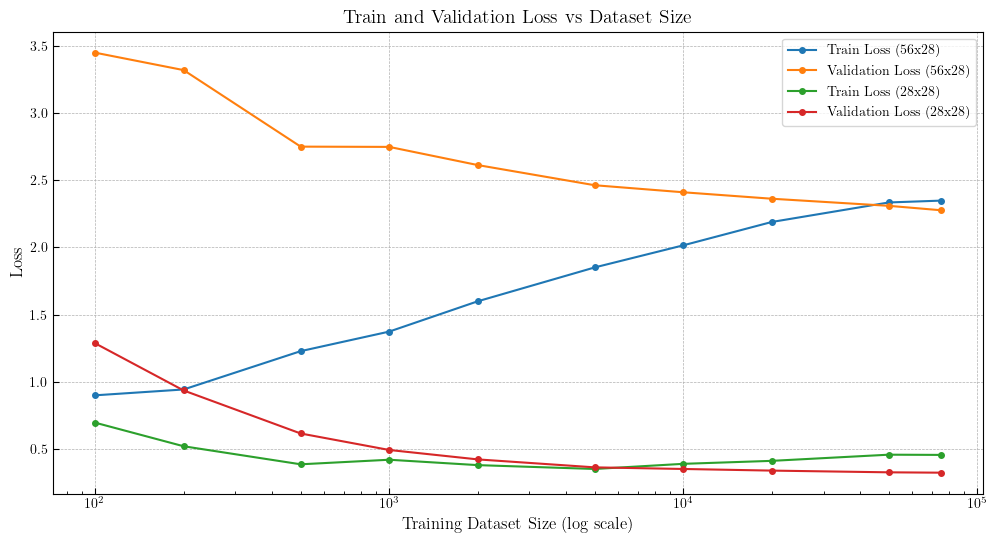

In [8]:
# Call the plot function
plot_results(
    training_sizes=training_sizes,
    accuracies_56x28=accuracies_56x28,
    accuracies_28x28=accuracies_28x28,
    train_losses_56x28=train_losses_56x28,
    val_losses_56x28=val_losses_56x28,
    train_losses_28x28=train_losses_28x28,
    val_losses_28x28=val_losses_28x28
)
